<a href="https://colab.research.google.com/github/mjoeli/csb_project/blob/main/MSc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
import re
from glob import glob
import os
import random
from tqdm import tqdm

import statsmodels.api as sm
from scipy import stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

Directories

In [127]:
rel_data_dir_full = './drive/MyDrive/master_thesis/data/sharew8_all/'
rel_data_dir_easy = './drive/MyDrive/master_thesis/data/sharew8_easy/'
outdir = './drive/MyDrive/master_thesis/Project'
outdir_casp = './drive/MyDrive/master_thesis/casp_output'
outdir_casp_OA = './drive/MyDrive/master_thesis/casp_OA_output'
outdir_linearReg = './drive/MyDrive/master_thesis/LinearReg_output'
outdir_age = './drive/MyDrive/master_thesis/age/'
outdir_casp = './drive/MyDrive/master_thesis/casp/'

In [128]:
'''
Wave 8 Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 00:53:53
'''
all_files = glob(f"{rel_data_dir_full}*.dta")

'''
easySHARE Release 8.0.0
DOI: 10.6103/SHARE.easy.800
2022-02-10 01:00:22
'''
easy_files = glob(f"{rel_data_dir_easy}*.dta")

'''
Wave 8 Activities (AC) Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 01:04:04
'''
ac_files = glob(f"{rel_data_dir_full}dta/**/*.dta", recursive=True)

Loading data from SHARE wav 8 (2019-2021)

In [129]:
df_easy = pd.read_stata(easy_files[0])
df_ac = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_ac.dta'))
df_gv = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_health.dta'))
df_ph = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_ph.dta'))

Merging data

In [130]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [131]:
df = df_easy.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df_ac[get_common_columns(df_ac, df)], \
              right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_gv[get_common_columns(df_gv, df)], \
              right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_ph[get_common_columns(df_ph, df)], \
              right_on=['mergeid'], how='left')

df = df[df['wave'] == 8]

'''cols = ['mergeid', 'female', 'age', 'country', 'casp', 'ac014_', 'ac015_'
        ,'ac016_', 'ac017_', 'ac018_', 'ac019_', 'ac020_', 'ac021_', 'ac022_'
        , 'ac023_', 'ac024_', 'ac025_', 'ph003_', 'ph006d20', 'ph087d2', 'ph087d3']'''

cols = ['mergeid', 'female', 'age','bmi', 'country', 'casp'
        , 'ph003_', 'ph006d20', 'ph087d2', 'ph087d3']

df = df.loc[:, cols]

Data prep

In [132]:
def map_no_info(df, columns: list[str] = ['casp']):
  df = df.copy()
  for c in columns:
      df.loc[:, c] = df[c].replace({
          '-15. no information': -1,
          '-13. not asked in this wave': -1,
          '-16. no drop-off (information in drop-off in this wave)': -1,
      })
      df[c] = df[c].astype(float)
  return df

def remove_numbers(cell_value):
  digit = r'\d+\.'
  matches = re.findall(digit, cell_value)
  if matches:
      return ''.join(filter(str.isalpha, cell_value))
  else:
      return cell_value

def map_selected_num(df, columns: list[str]):
  df = df.copy()
  for c in columns:
      df.loc[:, c] = df[c].map({
          'Selected': 1,
          'Not selected': 0,
          1: 1,
          0: 0,
      })
  return df

def map_bmi_num(df, columns: list[str] = ['bmi']):
  df = df.copy()
  for c in columns:
    df.loc[:, c] = df[c].replace({
        '-15. no information': -1,
          '-13. not asked in this wave': -1,
          "-12. don't know / refusal": -1,
          '-3. implausible value/suspected wrong': -1,
      })
    df[c] = df[c].astype(float)
  return df


In [133]:
df = map_no_info(df)
df = map_bmi_num(df)

df['country'] = df['country'].apply(remove_numbers)

#                        Osteoarthritis, pain hips, pain knee
df = map_selected_num(df, ['ph006d20', 'ph087d2', 'ph087d3'])
df['OA_conv'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) |
          ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

df.rename(columns={'ph006d20': 'OA'}, inplace=True)
df.rename(columns={'ph087d2': 'pain_hips'}, inplace=True)
df.rename(columns={'ph087d3': 'pain_knees'}, inplace=True)

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(int)

<ipython-input-132-4f7a0f5c04c8>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, c] = df[c].replace({
<ipython-input-132-4f7a0f5c04c8>:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, c] = df[c].replace({
<ipython-input-132-4f7a0f5c04c8>:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,

Drop missing values (NaN, -1) in CASP or OA

In [134]:
count = len(df.index)
df = df[(df['casp'] != -1)]
df = df[(df['age'] >= 50)]
df.dropna(subset=['OA'],inplace=True)
df['OA'] = df['OA'].astype(int)
valid_count = len(df.index)
print("Anzahl der Datensätze:", count, "\nAnzahl valider Datensätze:",
      valid_count, "(", valid_count/count*100, "%)")

Anzahl der Datensätze: 46733 
Anzahl valider Datensätze: 42656 ( 91.27597201121263 %)


Dataset:

In [135]:
df
df.to_csv(os.path.join(outdir, f'df.csv'), sep='\t', index=False, header=True)

**Descriptive statistics**

In [136]:
gender_count = df['female'].value_counts()
gender_per = gender_count / len(df) *100
OA_count = df['OA'].value_counts()
OA_count_conv = df['OA_conv'].value_counts()

print(pd.DataFrame({'Gender Count': gender_count,
                    'Gender (%)': gender_per,
                    'OA Count': OA_count,
                    'OA Conv.': OA_count_conv}),"\n")

   Gender Count  Gender (%)  OA Count  OA Conv.
0         18165   42.584865     34077     38511
1         24491   57.415135      8579      4145 



Slope: -0.01890932160913706, Intercept: 37.43303405896638, R-squared: 0.003374423542143027,         
P-value: 0.7780421204347622, Standard error: 0.06633405484449653


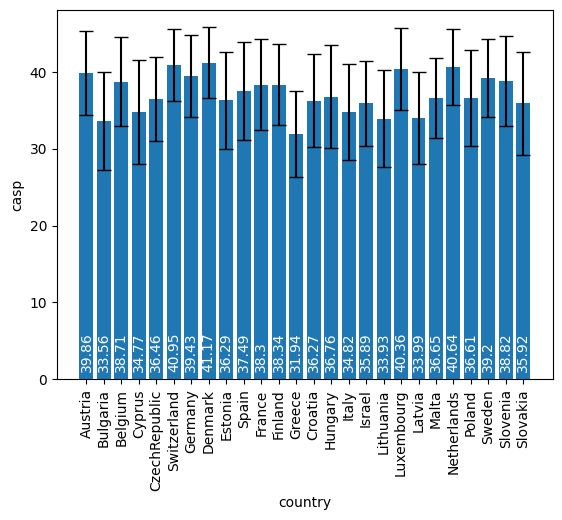

In [137]:
c_list = df['country'].unique().to_list()

stats = df.groupby('country')['casp'].agg(['mean', 'std']).loc[c_list] \
                                                          .reset_index()

fig, ax = plt.subplots()
bars = ax.bar(stats['country'], stats['mean'], yerr=stats['std'], capsize=5)
# yerr: specify the std for each bar, capsize: length of the error bars
ax.set_ylabel('casp')
ax.set_xlabel('country')
plt.xticks(rotation=90)

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(stats.index,
                                                         stats['mean'])

print(f"Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}, \
        \nP-value: {p_value}, Standard error: {std_err}")

for i, mean in enumerate(stats['mean']):
    ax.text(i, +1, round(mean, 2), ha='center', va='bottom',rotation=90
            ,color='white')

plt.show()

In [138]:
country_counts = df['country'].value_counts()
total_records = len(df)

country_percentages = (country_counts / total_records) * 100

mean_age = df.groupby('country')['age'].mean()

gender_counts = df.groupby(['country', 'female']).size().unstack()

OA_counts = df.groupby(['country', 'OA']).size().unstack()
OA_counts = OA_counts[[0, 1]]
OA_per = (OA_counts[1] / country_counts) *100

mean_casp = df.groupby('country')['casp'].mean()

country_stats = pd.concat([country_counts, country_percentages, mean_age
                           ,gender_counts, OA_per, mean_casp], axis=1)
country_stats.columns = ['Count','%','age\n(mean)', 'Male', 'Female'
                         , 'OA(%)', 'CASP\n(mean)']

country_stats = country_stats.round(2)

country_stats.to_csv(os.path.join(outdir, 'country_stats_slim.csv'), index=True)
print(country_stats)

               Count     %  age\n(mean)  Male  Female  OA(%)  CASP\n(mean)
Greece          2903  6.81        69.44  1238    1665  16.16         31.94
Estonia         2775  6.51        71.52   976    1799  14.38         36.29
Germany         2714  6.36        69.49  1269    1445  25.53         39.43
CzechRepublic   2485  5.83        71.29   970    1515  28.09         36.46
Slovenia        2362  5.54        70.70   953    1409   8.68         38.82
France          2288  5.36        70.64   962    1326  40.52         38.30
Sweden          2251  5.28        72.99  1048    1203  21.59         39.20
Denmark         2066  4.84        69.03   951    1115  25.31         41.17
Italy           2055  4.82        70.20   894    1161  15.67         34.82
Poland          1966  4.61        67.72   869    1097  31.99         36.61
Spain           1908  4.47        72.65   829    1079  14.73         37.49
Belgium         1873  4.39        69.67   836    1037  35.13         38.71
Netherlands     1859  4.3

**Group countries into regions**

Group countires as following: *https://unstats.un.org/unsd/publication/SeriesM/Series_M49_Rev3(1996)_en.pdf*

**Eastern Europe:** Bulgaria, Czech Republic, Hungary, Poland, Slovakia (5)

**Nothern Europe:** Denmark, Estonia, Finnland, Latvia, Lithuania, Norway, Sweden (7)

**Southern Europe:** Italy, Slovenia, Spain, Greece, Croatia, Malta (6)

**Western Europe:** Austria, France, Germany, Luxembourg, Netherlands, Switzerland, Belgium (7)

**Western Asia:** Israel, Cyprus (2)

Total countries included: 27

In [139]:
list_nE = ['Denmark', 'Estonia', 'Finland', 'Latvia', 'Lithuania',
           'Norway', 'Sweden']
list_wE = ['Austria', 'Belgium', 'France', 'Germany', 'Luxembourg',
           'Netherlands', 'Switzerland']
list_sE = ['Greece', 'Italy', 'Spain', 'Croatia', 'Malta', 'Slovenia']
list_eE = ['Bulgaria', 'CzechRepublic', 'Hungary', 'Poland', 'Slovakia']
list_wA = ['Israel', 'Cyprus']

df['region'] = df['country'].apply(lambda x: 'wE' if x in list_wE else
 ('sE' if x in list_sE else ('nE' if x in list_nE else ('eE' if x in list_eE else
  ('wA' if x in list_wA else ((np.nan)))))))

print(f'South Europe (sE): {list_sE}')
print(f'West Europe (wE): {list_wE}')
print(f'North Europe (nE): {list_nE}')
print(f'East Europe (eE): {list_eE}')
print(f'Isreael and Cyprus (wA): {list_wA}')

region_counts = df['region'].value_counts()
total_records = len(df)
region_percentages = (region_counts / total_records) * 100
mean_age = df.groupby('region')['age'].mean()
gender_counts = df.groupby(['region', 'female']).size().unstack()
gender_percentages = (gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100).round(2)
OA_counts = df.groupby(['region', 'OA']).size().unstack()
OA_counts = OA_counts[[0, 1]]
OA_per = (OA_counts[1] / region_counts) *100
mean_casp = df.groupby('region')['casp'].mean()

region_stats = pd.concat([region_counts, region_percentages, mean_age
                           ,gender_percentages, OA_per, mean_casp], axis=1)
region_stats.columns = ['Count', '%','age (mean)', 'Male', 'Female'
                         , 'OA (%)', 'CASP (mean)']

region_stats = region_stats.round(2)

region_stats.to_csv(os.path.join(outdir, 'region_stats.csv'), index=True)
print('\n--- descriptive statistic ---\n')
print(region_stats)

South Europe (sE): ['Greece', 'Italy', 'Spain', 'Croatia', 'Malta', 'Slovenia']
West Europe (wE): ['Austria', 'Belgium', 'France', 'Germany', 'Luxembourg', 'Netherlands', 'Switzerland']
North Europe (nE): ['Denmark', 'Estonia', 'Finland', 'Latvia', 'Lithuania', 'Norway', 'Sweden']
East Europe (eE): ['Bulgaria', 'CzechRepublic', 'Hungary', 'Poland', 'Slovakia']
Isreael and Cyprus (wA): ['Israel', 'Cyprus']

--- descriptive statistic ---

    Count      %  age (mean)   Male  Female  OA (%)  CASP (mean)
wE  12887  30.21       70.35  44.24   55.76   25.80        39.62
sE  11148  26.13       70.21  42.69   57.31   13.95        35.65
nE  10303  24.15       70.35  41.45   58.55   18.98        37.64
eE   7048  16.52       68.75  41.44   58.56   22.76        36.10
wA   1270   2.98       72.25  40.39   59.61   10.94        35.46


Slope: 0.48644822094922946, Intercept: 35.92178668904363, R-squared: 0.19321027895727036,       
P-value: 0.45892296865334353, Standard error: 0.5739063849682289


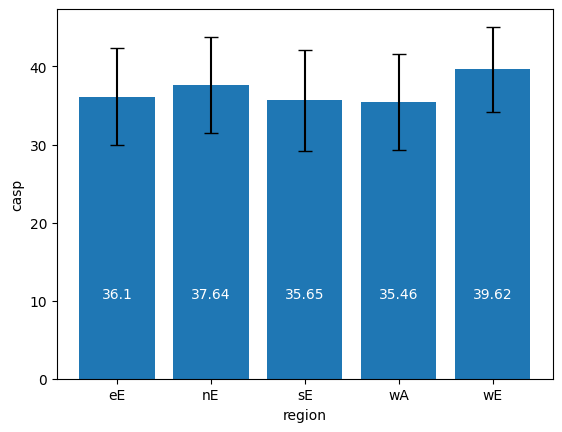

In [140]:
stats = df.groupby('region')['casp'].agg(['mean', 'std']).reset_index()

fig, ax = plt.subplots()
ax.bar(stats['region'], stats['mean'], yerr=stats['std'], capsize=5)
# yerr: specify the std for each bar, capsize: length of the error bars
ax.set_ylabel('casp')
ax.set_xlabel('region')

# linear regression to see if the means are related to the country
slope, intercept, r_value, p_value, std_err = linregress(stats.index,
                                                         stats['mean'])
print(f"Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}, \
      \nP-value: {p_value}, Standard error: {std_err}")

for i, mean in enumerate(stats['mean']):
    ax.text(i, +10, round(mean, 2), ha='center', va='bottom',color='white')

plt.show()

Slope: 0.5100281199604524, Intercept: 69.36028657568536, R-squared: 0.42105513961396834,       
P-value: 0.23615180513615686, Standard error: 0.3452888932199312


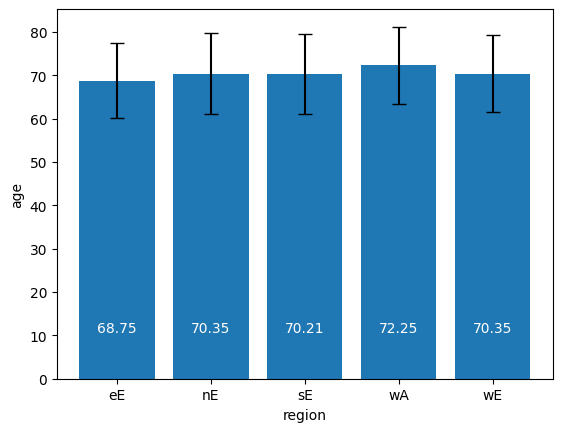

In [141]:
stats = df.groupby('region')['age'].agg(['mean', 'std']).reset_index()

fig, ax = plt.subplots()
ax.bar(stats['region'], stats['mean'], yerr=stats['std'], capsize=5)
# yerr: specify the std for each bar, capsize: length of the error bars
ax.set_ylabel('age')
ax.set_xlabel('region')

# linear regression to see if the means are related to the country
slope, intercept, r_value, p_value, std_err = linregress(stats.index,
                                                         stats['mean'])
print(f"Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}, \
      \nP-value: {p_value}, Standard error: {std_err}")

for i, mean in enumerate(stats['mean']):
    ax.text(i, +10, round(mean, 2), ha='center', va='bottom',color='white')

plt.show()

Output CASP data as .txt file per region

In [142]:
regions = ['nE', 'wE', 'sE', 'eE', 'wA']
weighted_means = []
weights = []
total_weight = 0

for region in regions:
    if region in df['region'].values:
        r_df = df[df['region'] == region]

        mean = r_df['casp'].mean()
        weight = len(r_df)
        weighted_mean = mean * weight
        weighted_means.append(weighted_mean)
        weights.append(weight)
        total_weight += weight

        casp = r_df['casp'].to_list()
        output_file = os.path.join(outdir_casp, f'client_{region}.txt')
        with open(output_file, 'w') as outfile:
            outfile.write(','.join(str(i) for i in casp))

w_avg_region = sum(weighted_means) / total_weight
print(w_avg_region)

37.40024849962491


Output CASP data as .txt file randomly distributed (4 clients)

In [143]:
# shuffel data randomly (-> mix countries)
df_random = df['casp'].sample(frac=1, random_state=42).tolist()
random.shuffle(df_random)

# Split data into equal parts (4 clients)
split_size = len(df_random) // 4
splits = [df_random[i*split_size:(i+1)*split_size] for i in range(4)]

# Save each split to file
for i, split in enumerate(splits):
    with open(os.path.join(outdir_casp, f'random_client_{i+1}.txt'), 'w') as f:
        f.write(','.join(str(item) for item in split))

Output CASP data as .txt file per region (same amount)

In [144]:
# Dictionary to store lists of 'casp' values for each region
region_casp_lists = {region: [] for region in df['region'].unique()}

max_participants_per_region = 1270
df_random = df.sample(frac=1, random_state=42)

for _, row in df_random.iterrows():
    region = row['region']
    casp_value = row['casp']

    if len(region_casp_lists[region]) < max_participants_per_region:
        region_casp_lists[region].append(casp_value)

    # Check if enough participants for each region is collected
    if all(len(casp_list) >= max_participants_per_region for casp_list in region_casp_lists.values()):
        break

# Display the lengths of the casp lists for verification
for region, casp_list in region_casp_lists.items():
    print(f"Region: {region}, Length: {len(casp_list)}")

# Calculating weighted means and writing data to files
weighted_means = []
weights = []
total_weight = 0

for i, (region, casp_list) in enumerate(region_casp_lists.items()):
    mean = sum(casp_list) / len(casp_list)
    weight = len(casp_list)
    weighted_mean = mean * weight
    weighted_means.append(weighted_mean)
    weights.append(weight)
    total_weight += weight

    with open(os.path.join(outdir_casp, f'client_{i+1}_{region}_short.txt'), 'w') as f:
        f.write(','.join(str(item) for item in casp_list))

w_avg_region_equ = sum(weighted_means) / total_weight
print(w_avg_region_equ)

Region: wE, Length: 1270
Region: eE, Length: 1270
Region: wA, Length: 1270
Region: nE, Length: 1270
Region: sE, Length: 1270
37.01984251968504


**MEAN CASP**

In [145]:
casp_mean_total = df['casp'].mean()

print(f'Total mean = {casp_mean_total.round(2)}',
      f'\nWeighted Average: {w_avg_region.round(2)}',
      f'\nWeighted Average of mean, random data but same amount of region: {w_avg_region_equ}')

Total mean = 37.4 
Weighted Average: 37.4 
Weighted Average of mean, random data but same amount of region: 37.01984251968504


Output CASP & OA data randomly distributed (4 clients)

In [146]:
OA_output = pd.concat([df['OA'], df['casp']], axis=1)
# shuffel data randomly (-> mix countries)
df_random = OA_output.sample(frac=1, random_state=42)
# split df in equal parts (4 clients)
split_size = len(df_random) // 4
splits = [df_random[i*split_size:(i+1)*split_size] for i in range(4)]

for i, split in enumerate(splits):
  split.to_csv(os.path.join(outdir_casp_OA, f'random_client_{i+1}.txt'), index=False,
               header=False, sep=',')

Output CASP & OA data per region

In [147]:
region_names = ['north Europe', 'west Europe', 'south Europe', 'east Europe',
                'west Asia']
regions = ['nE', 'wE', 'sE', 'eE', 'wA']
correlations = []
weighted_correlations = []
weights = []
total_weight = 0

for i, region in enumerate(regions):
  if region in df['region'].values:
    r_df = df.loc[df['region'] == region, ['OA', 'casp']].copy()
    corr, p_val = pearsonr(r_df['OA'], r_df['casp'])
    weight = len(r_df)
    weighted_correlation = corr * weight
    weighted_correlations.append(weighted_correlation)
    weights.append(weight)
    total_weight += weight
    print(f"Correlation between CASP and OA in {region_names[i]}: {corr.round(3)},\
    p-value: {p_val.round(2)}\nNumber of respondents: {len(r_df)}")
    correlations.append(corr)

    r_df = df.loc[df['region'] == region, ['OA', 'casp']].copy()
    r_df.to_csv(os.path.join(outdir_casp_OA, f'{region}.txt'), index=False
                , header=False, sep=',')

avg_corr_region = sum(correlations) / len(correlations)
print(f"Average correlation per region: {avg_corr_region.round(3)}")
w_avg_region = np.sum(weighted_correlations) / total_weight
print(f'Weighted Average: {w_avg_region.round(3)}')

Correlation between CASP and OA in north Europe: -0.05,    p-value: 0.0
Number of respondents: 10303
Correlation between CASP and OA in west Europe: -0.172,    p-value: 0.0
Number of respondents: 12887
Correlation between CASP and OA in south Europe: -0.165,    p-value: 0.0
Number of respondents: 11148
Correlation between CASP and OA in east Europe: -0.145,    p-value: 0.0
Number of respondents: 7048
Correlation between CASP and OA in west Asia: -0.134,    p-value: 0.0
Number of respondents: 1270
Average correlation per region: -0.133
Weighted Average: -0.135


Output CASP & OA data per region (same amount)

In [148]:
correlations = []
weighted_correlations = []
weights = []
total_weight = 0
max_participants_per_region = 1270

# Shuffle df randomly
df_random = df.sample(frac=1, random_state=42)

for i, region in enumerate(regions):
    if region in df['region'].values:
        r_df = df_random[df_random['region'] == region][['OA', 'casp']].copy()

        # Check if the region has more than max_participants_per_region samples
        if len(r_df) > max_participants_per_region:
            r_df = r_df.sample(n=max_participants_per_region, random_state=42)

        # Calculate Pearson correlation coefficient
        corr, p_val = pearsonr(r_df['OA'], r_df['casp'])

        weight = len(r_df)
        weighted_correlation = corr * weight
        weighted_correlations.append(weighted_correlation)
        weights.append(weight)
        total_weight += weight
        correlations.append(corr)
        print(f"Correlation between CASP and OA in {region_names[i]}: {corr.round(3)}, \
              p-value: {p_val.round(2)}\nNumber of respondents: {len(r_df)}")

        # Write 'OA' and 'casp' columns to a CSV file
        output_file = os.path.join(outdir_casp_OA, f'client_short_{region}.txt')
        r_df.to_csv(output_file, index=False, header=False, sep=',')

    # Check if the total_weight exceeds the 'max'
    if total_weight >= max_participants_per_region * len(regions):
        break

avg_region_short = sum(correlations) / len(correlations)
print(f"Average correlation per region: {avg_region_short.round(3)}")
w_avg_region_short = np.sum(weighted_correlations) / total_weight
print(f'Weighted Average: {w_avg_region_short.round(3)}')


Correlation between CASP and OA in north Europe: -0.063,               p-value: 0.03
Number of respondents: 1270
Correlation between CASP and OA in west Europe: -0.186,               p-value: 0.0
Number of respondents: 1270
Correlation between CASP and OA in south Europe: -0.172,               p-value: 0.0
Number of respondents: 1270
Correlation between CASP and OA in east Europe: -0.149,               p-value: 0.0
Number of respondents: 1270
Correlation between CASP and OA in west Asia: -0.134,               p-value: 0.0
Number of respondents: 1270
Average correlation per region: -0.141
Weighted Average: -0.141


**Pearson correlation between CASP and OA**

In [149]:
corr, p_val = pearsonr(df['OA'], df['casp'])
print(f'Total correlation = {corr.round(2)}',
      f'\nWeighted Average correlation per region: {w_avg_region.round(2)}',
      f'\nAverage of correlation, random data but same amount of region: {avg_region_short.round(2)}')

Total correlation = -0.1 
Weighted Average correlation per region: -0.14 
Average of correlation, random data but same amount of region: -0.14


**Test linear assumptions**

1. **Linearity of the Relationship:** Check if the relationship between `x` and `y` appears to be linear -> if the points roughly fall along a straight line, it suggests a linear relationship between the variables.

2. **Independence of Residuals:** Check if the residuals are independent of each other.

3. **Homoscedasticity (Constant Variance):** Check if the spread of the residuals is roughly constant across all quantiles -> if the spread is not consistent and varies with the quantiles, it indicates heteroscedasticity.

4. **Normality of Residuals:** Check if the residuals are normally distributed.



*residuals (the vertical distance between the points and the fitted line)
-> differences between the observed values of the dependent variable (y) and the predicted values (ŷ) based on the regression model.

*https://www.statology.org/linear-regression-assumptions/*

In [150]:
from scipy import stats
def qqplot(x, y, title, palette=cm.viridis, ax=None, *args, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)

    # Linear Regression
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    y_pred = intercept + slope * x

    # Residuals
    residuals = y - y_pred

    # Plot the regression line
    plt.plot(x, y_pred, color='red', label='Regression Line')

    # Plot residuals
    plt.scatter(x, residuals, color='blue', label='Residuals')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.legend()
    plt.show()

<ipython-input-150-73957a0ab3fb>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)


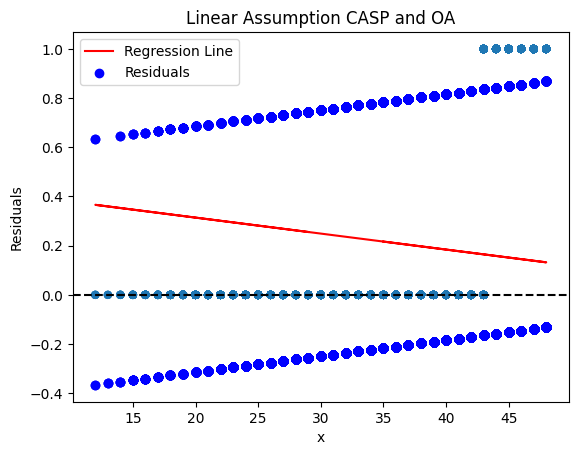

<ipython-input-150-73957a0ab3fb>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)


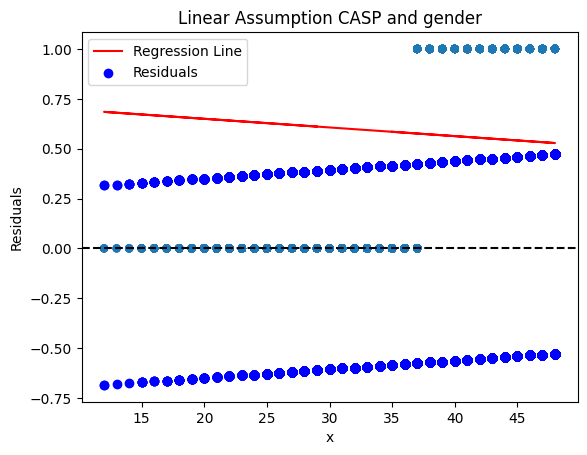

<ipython-input-150-73957a0ab3fb>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=xr, y=yr, ax=ax, edgecolor="none", palette=palette, *args, **kwargs)


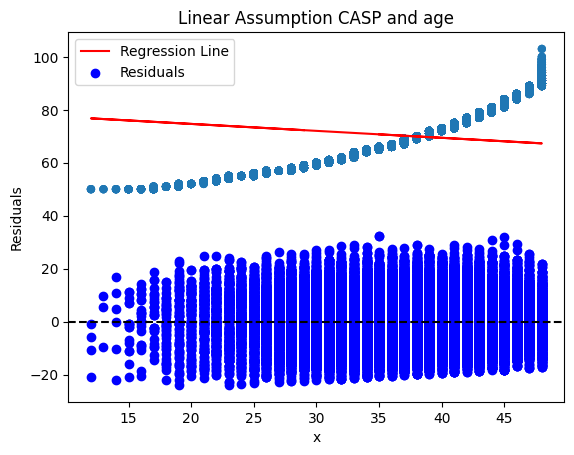

In [151]:
qqplot(df['casp'], df['OA'], 'Linear Assumption CASP and OA')
qqplot(df['casp'], df['female'], 'Linear Assumption CASP and gender')
qqplot(df['casp'], df['age'], 'Linear Assumption CASP and age')

In [152]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['OA', 'age', 'female']]
y = df['casp']
model = LinearRegression().fit(X, y)
total_intercept = model.intercept_
total_coef = model.coef_

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# VIF = 1: No multicollinearity
# VIF > 1 and < 5: Moderate multicollinearity
# VIF >= 5: Multicollinearity

  Feature       VIF
0      OA  1.281216
1     age  2.425239
2  female  2.312352


10-fold-CV split random (4 clients)

In [153]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
num_clients = 4
global_test_sets = []

for i, (train_index, test_index) in enumerate(kf.split(df)):
    df_train = df.iloc[train_index][['OA', 'age', 'female', 'casp']]
    df_test = df.iloc[test_index][['OA', 'age', 'female', 'casp']]

    # Randomly shuffle the training data within the fold
    df_train_shuffled = df_train.sample(frac=1, random_state=42)

    # Split the shuffled training data into 4 clients with unique data
    client_data_size = len(df_train_shuffled) // num_clients
    client_datasets = []

    # Distribute unique data to each client
    for client_id in range(num_clients):
        start_idx = client_id * client_data_size
        end_idx = (client_id + 1) * client_data_size if client_id < num_clients - 1 else None
        client_data = df_train_shuffled.iloc[start_idx:end_idx]
        client_datasets.append(client_data)

    for client_id, client_data in enumerate(client_datasets):
        client_data.to_csv(os.path.join(outdir_linearReg, f'random/c{client_id + 1}/fold_{i + 1}_train.csv'), index=False, header=True)

    global_test_sets.append(df_test)

for i, test in enumerate(global_test_sets):
    for j in range(num_clients):
        test.to_csv(os.path.join(outdir_linearReg, f'random/c{j+1}/fold_{i + 1}_test.csv'), index=False, header=True)



10-fold-CV split per region

In [154]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)


for i, (train_index, test_index) in enumerate(kf.split(df)):
  df_train = df.iloc[train_index]
  df_test = df.iloc[test_index]

  for region in regions:
    df_train_region = df_train[df_train['region'] == region]
    df_test_region = df_test[df_test['region'] == region]

    X_train_region = df_train_region[['OA', 'age', 'female']].values
    y_train_region = df_train_region['casp'].values
    X_test_region = df_test_region[['OA', 'age', 'female']].values
    y_test_region = df_test_region['casp'].values

    X_train_region_df = pd.DataFrame(X_train_region, columns=['OA', 'age', 'female'])
    y_train_region_df = pd.DataFrame(y_train_region, columns=['casp'])
    X_test_region_df = pd.DataFrame(X_test_region, columns=['OA', 'age', 'female'])
    y_test_region_df = pd.DataFrame(y_test_region, columns=['casp'])

    X_train_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_Xtrain_{region}.csv'), index=False, header=True)
    y_train_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_ytrain_{region}.csv'), index=False, header=True)
    X_test_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_Xtest_{region}.csv'), index=False, header=True)
    y_test_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_ytest_{region}.csv'), index=False, header=True)

10-fold-CV split per region (N=1270)

In [155]:
max_participants_per_region = 1270
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kf.split(df)):
  df_train = df.iloc[train_index]
  df_test = df.iloc[test_index]
  region_data = {}

  # Randomly sample 1270 data points for each region
  for region in regions:
    region_df = df_train[df_train['region'] == region]
    if len(region_df) >= max_participants_per_region:
      region_data[region] = region_df.sample(n=max_participants_per_region, random_state=42)
    else:
      region_data[region] = region_df

    # Combine region-specific data into train and test sets
    df_train_region = pd.concat(list(region_data.values()))
    df_test_region = df_test[df_test['region'].isin(region_data.keys())]

    X_train_region = df_train_region[['OA', 'age', 'female']].values
    y_train_region = df_train_region['casp'].values
    X_test_region = df_test_region[['OA', 'age', 'female']].values
    y_test_region = df_test_region['casp'].values

    X_train_region_df = pd.DataFrame(X_train_region, columns=['OA', 'age', 'female'])
    y_train_region_df = pd.DataFrame(y_train_region, columns=['casp'])
    X_test_region_df = pd.DataFrame(X_test_region, columns=['OA', 'age', 'female'])
    y_test_region_df = pd.DataFrame(y_test_region, columns=['casp'])

    X_train_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_Xtrain_{region}_short.csv'), index=False, header=True)
    y_train_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_ytrain_{region}_short.csv'), index=False, header=True)
    X_test_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_Xtest_{region}_short.csv'), index=False, header=True)
    y_test_region_df.to_csv(os.path.join(outdir_linearReg, f'fold_{i+1}_ytest_{region}_short.csv'), index=False, header=True)

Split data & save data

In [181]:
def split_and_save_datasets(datasets, outdir, num_folds=5, random_state=42):
  combine_tests = [[] for _ in range(num_folds)]

  for i, dataset in enumerate(datasets):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    for j, (train_index, test_index) in enumerate(kf.split(dataset)):
      train_data = dataset.iloc[train_index]
      test_data = dataset.iloc[test_index]

      train_data.to_csv(os.path.join(outdir, f'c{i+1}/fold_{j+1}_train.csv'), index=False, header=True)
      combine_tests[j].append(test_data)

  for i in range(len(datasets)):
    for j, test_data_list in enumerate(combine_tests):
      concatenated_test_data = pd.concat(test_data_list)
      concatenated_test_data.to_csv(os.path.join(outdir, f'c{i+1}/fold_{j+1}_test.csv'), index=False, header=True)

In [157]:
df_sub = df[['OA', 'age', 'female', 'casp']]

unbalanced data - age

In [158]:
print("age min: ", df['age'].min(), "\nage max: ", df['age'].max(),
      "\nage mean: ", df['age'].mean())

age min:  50 
age max:  103 
age mean:  70.10446361590398


2 Clients


100%|██████████| 21328/21328 [00:28<00:00, 745.27it/s]


88.98743435858965
68.99672391541745
client1, N = 21328
client2, N = 40292


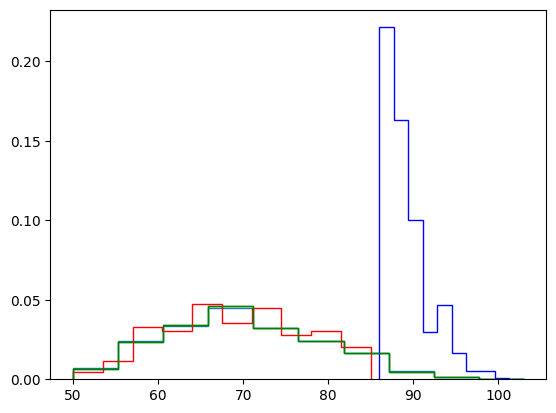

In [177]:
n_target = len(df_sub) // 2
x_target_distribution = df_sub["age"].sample(n_target, replace=False)

plt.hist(df_sub["age"], histtype="step", density=True)
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

def sample_instance_with_x(x, eps=10):
    try:
        return df_sub.loc[abs(df_sub["age"] - x) < eps].sample(1)
    except ValueError: # fallback if no instance possible
        return None

df_sampled_ = [sample_instance_with_x(95) for x in tqdm(x_target_distribution)]
df_sampled = pd.concat(df_sampled_)

df_not_sampled = df_sub.drop(df_sampled.index)

plt.hist(df_sampled["age"], histtype="step", density=True, color='blue')
plt.hist(df_not_sampled["age"], histtype="step", density=True, color='red')
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

print(df_sampled["age"].mean())
print(df_not_sampled["age"].mean())

print(f'client1, N = {len(df_sampled)}')
print(f'client2, N = {len(df_not_sampled)}')

df_sampled.to_csv(os.path.join(outdir_age, f'client1.csv'), index=False, header=True)
df_sampled.to_csv(os.path.join(outdir_age, f'3clients/client1.csv'), index=False, header=True)
df_not_sampled.to_csv(os.path.join(outdir_age, f'client2.csv'), index=False, header=True)

In [182]:
split_and_save_datasets([df_sampled, df_not_sampled], outdir_age, num_folds=5, random_state=42)

In [160]:
'''n_target = len(df_sub) // 2
x_target_distribution = df_sub["age"].sample(n_target, replace=False)

plt.hist(df_sub["age"], histtype="step", density=True)
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

def sample_instance_with_x(x_min, x_max, used_indices):
  try:
    available_indices = df_sub.loc[(df_sub["age"] >= x_min) & (df_sub["age"] <= x_max)].index.difference(used_indices)
    sample_indices = np.random.choice(available_indices, 1, replace=False)
    used_indices.update(sample_indices)
    return df_sub.loc[sample_indices]
  except ValueError:  # fallback if no instance possible
    return df_sub.sample(1)

def split_data_into_x_datasets(x_distribution):
  datasets = []
  used_indices = set()
  x_ranges = [(50, 75), (75, 103)]

  for x_min, x_max in x_ranges:
    df_sampled_ = [sample_instance_with_x(x_min, x_max, used_indices) for _ in tqdm(x_distribution)]
    df_sampled = pd.concat(df_sampled_)
    datasets.append(df_sampled)
  return datasets

datasets = split_data_into_x_datasets(x_target_distribution)

for i, dataset in enumerate(datasets):
  plt.hist(dataset["age"], histtype="step", density=True, label=f'Dataset {i+1}')

plt.legend()
plt.show()

for i, dataset in enumerate(datasets):
  print(dataset["age"].mean())
  print(f'Dataset {i+1}, N = {len(dataset)}')
  #dataset.to_csv(os.path.join(outdir_age, f'5clients/client_{i+1}.csv'), index=False, header=True)'''

'n_target = len(df_sub) // 2\nx_target_distribution = df_sub["age"].sample(n_target, replace=False)\n\nplt.hist(df_sub["age"], histtype="step", density=True)\nplt.hist(x_target_distribution, histtype="step", density=True, color=\'green\')\n\ndef sample_instance_with_x(x_min, x_max, used_indices):\n  try:\n    available_indices = df_sub.loc[(df_sub["age"] >= x_min) & (df_sub["age"] <= x_max)].index.difference(used_indices)\n    sample_indices = np.random.choice(available_indices, 1, replace=False)\n    used_indices.update(sample_indices)\n    return df_sub.loc[sample_indices]\n  except ValueError:  # fallback if no instance possible\n    return df_sub.sample(1)\n\ndef split_data_into_x_datasets(x_distribution):\n  datasets = []\n  used_indices = set()\n  x_ranges = [(50, 75), (75, 103)]\n\n  for x_min, x_max in x_ranges:\n    df_sampled_ = [sample_instance_with_x(x_min, x_max, used_indices) for _ in tqdm(x_distribution)]\n    df_sampled = pd.concat(df_sampled_)\n    datasets.append(df_s

3 clients


100%|██████████| 20146/20146 [00:53<00:00, 377.79it/s]


59.69160131043383
72.1131981713377
client2, N = 20146
client3, N = 30186


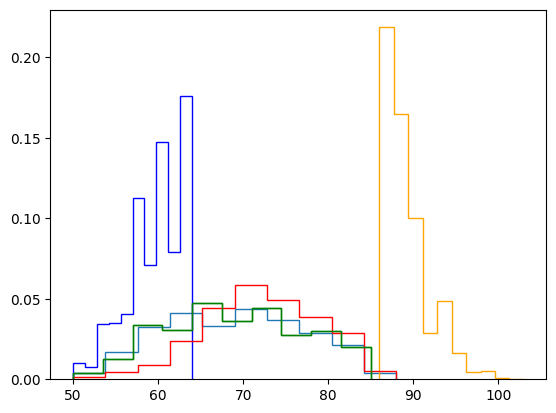

In [161]:
n_target = len(df_not_sampled) // 2
x_target_distribution = df_not_sampled["age"].sample(n_target, replace=False)

plt.hist(df_not_sampled["age"], histtype="step", density=True)
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

def sample_instance_with_x(x, eps=10):
    try:
        return df_not_sampled.loc[abs(df_not_sampled["age"] - x) < eps].sample(1)
    except ValueError: # fallback if no instance possible
        return df_not_sampled.sample(1)

client2_ = [sample_instance_with_x(55) for x in tqdm(x_target_distribution)]
client2 = pd.concat(client2_)

client3 = df_not_sampled.drop(client2.index)

plt.hist(df_sampled["age"], histtype="step", density=True, color='orange')
plt.hist(client2["age"], histtype="step", density=True, color='blue')
plt.hist(client3["age"], histtype="step", density=True, color='red')
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

print(client2["age"].mean())
print(client3["age"].mean())

print(f'client2, N = {len(client2)}')
print(f'client3, N = {len(client3)}')

client2.to_csv(os.path.join(outdir_age, f'3clients/client2.csv'), index=False, header=True)
client3.to_csv(os.path.join(outdir_age, f'3clients/client3.csv'), index=False, header=True)

In [183]:
split_and_save_datasets([df_sampled, client2, client3], outdir_age + '3clients', num_folds=5, random_state=42)

5 clients

Dataset 1 Stats:
Mean Age: 56.945539906103285
Number of Samples: 1065

Dataset 2 Stats:
Mean Age: 77.99180500105064
Number of Samples: 4759

Dataset 3 Stats:
Mean Age: 88.6470588235294
Number of Samples: 527

Dataset 4 Stats:
Mean Age: 69.187412202176
Number of Samples: 36305


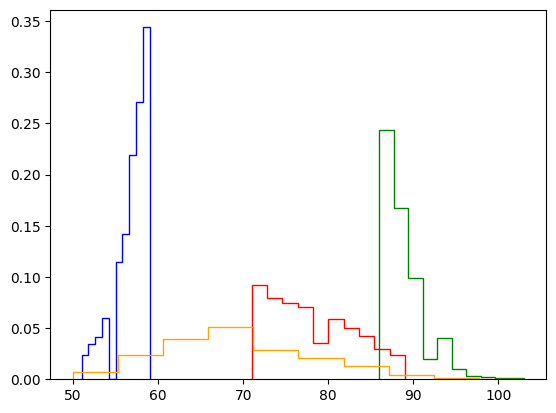

In [162]:
n_samples = len(df_sub)
n_forth = n_samples // 4

df_part1 = df_sub.iloc[:n_forth]
df_part2 = df_sub.iloc[n_forth:2 * n_forth]
df_part3 = df_sub.iloc[2 * n_forth:3 * n_forth]
df_part4 = df_sub.iloc[3 * n_forth:]


# Create masks to keep track of included instances for each part
included_mask1 = np.zeros(len(df_part1), dtype=bool)
included_mask2 = np.zeros(len(df_part2), dtype=bool)
included_mask3 = np.zeros(len(df_part3), dtype=bool)
included_mask4 = np.zeros(len(df_part4), dtype=bool)

# Create target age distributions for each client
x_target_distribution1 = df_part1["age"].sample(n_forth, replace=False)
x_target_distribution2 = df_part2["age"].sample(n_forth, replace=False)
x_target_distribution3 = df_part3["age"].sample(n_forth, replace=False)
x_target_distribution4 = df_part4["age"].sample(n_forth, replace=False)

def sample_instance_with_x(df_part, included_mask, x, eps=10):
    try:
        available_indices = np.where(~included_mask)[0]  # Find available indices
        df_subset = df_part.iloc[available_indices]
        closest_indices = available_indices[np.abs(df_subset["age"] - x) < eps]

        if len(closest_indices) > 0:
            selected_index = np.random.choice(closest_indices)
            included_mask[selected_index] = True  # Mark index as included
            return df_part.iloc[selected_index:selected_index + 1]
        else:
            return None
    except ValueError:  # fallback if no instance possible
        return None

# Sample instances for each target age distribution and create datasets
df_sampled1_ = [sample_instance_with_x(df_part1, included_mask1, 55, eps=5) for x in x_target_distribution1]
df_sampled1 = pd.concat([x for x in df_sampled1_ if x is not None])

df_sampled2_ = [sample_instance_with_x(df_part2, included_mask2, 80) for x in x_target_distribution2]
df_sampled2 = pd.concat([x for x in df_sampled2_ if x is not None])

df_sampled3_ = [sample_instance_with_x(df_part3, included_mask3, 95) for x in x_target_distribution3]
df_sampled3 = pd.concat([x for x in df_sampled3_ if x is not None])

# All remaining data is included in df_sampled4
df_sampled4 = pd.concat([df_part1[~included_mask1], df_part2[~included_mask2],
                        df_part3[~included_mask3], df_part4[~included_mask4]])

print("Dataset 1 Stats:")
print(f"Mean Age: {df_sampled1['age'].mean()}")
print(f"Number of Samples: {len(df_sampled1)}")

print("\nDataset 2 Stats:")
print(f"Mean Age: {df_sampled2['age'].mean()}")
print(f"Number of Samples: {len(df_sampled2)}")

print("\nDataset 3 Stats:")
print(f"Mean Age: {df_sampled3['age'].mean()}")
print(f"Number of Samples: {len(df_sampled3)}")

print("\nDataset 4 Stats:")
print(f"Mean Age: {df_sampled4['age'].mean()}")
print(f"Number of Samples: {len(df_sampled4)}")

plt.hist(df_sampled1["age"], histtype="step", density=True, color='blue')
plt.hist(df_sampled2["age"], histtype="step", density=True, color='red')
plt.hist(df_sampled3["age"], histtype="step", density=True, color='green')
plt.hist(df_sampled4["age"], histtype="step", density=True, color='orange')

df_sampled1.to_csv(os.path.join(outdir_age, '4clients/client1.csv'), index=False, header=True)
df_sampled2.to_csv(os.path.join(outdir_age, '4clients/client2.csv'), index=False, header=True)
df_sampled3.to_csv(os.path.join(outdir_age, '4clients/client3.csv'), index=False, header=True)
df_sampled4.to_csv(os.path.join(outdir_age, '4clients/client4.csv'), index=False, header=True)

In [184]:
split_and_save_datasets([df_sampled1, df_sampled2, df_sampled3, df_sampled4], outdir_age + '4clients', num_folds=5, random_state=42)

unbalanced data - casp

In [163]:
print("casp min: ", df['casp'].min(), "\ncasp max: ", df['casp'].max(),
      "\ncasp mean: ", df['casp'].mean())

casp min:  12.0 
casp max:  48.0 
casp mean:  37.40024849962491



100%|██████████| 21328/21328 [00:29<00:00, 728.71it/s]


21.696642910727682
37.90514675635783
client1, N = 21328
client2, N = 41327


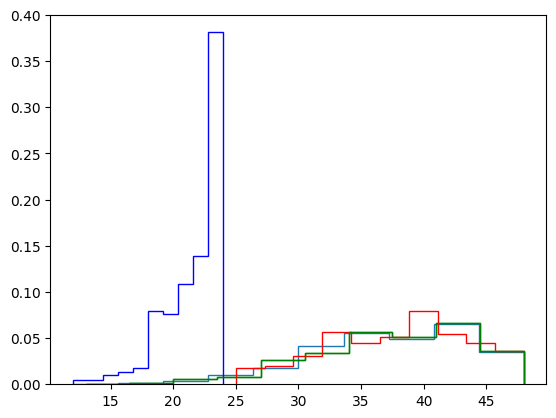

In [165]:
n_target = len(df_sub) // 2
x_target_distribution = df_sub["casp"].sample(n_target, replace=False)

plt.hist(df_sub["casp"], histtype="step", density=True)
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

def sample_instance_with_x(x, eps=10):
    try:
        return df_sub.loc[abs(df_sub["casp"] - x) < eps].sample(1)
    except ValueError: # fallback if no instance possible
        return None

df_sampled_ = [sample_instance_with_x(15) for x in tqdm(x_target_distribution)]
df_sampled = pd.concat(df_sampled_)

df_not_sampled = df_sub.drop(df_sampled.index)

plt.hist(df_sampled["casp"], histtype="step", density=True, color='blue')
plt.hist(df_not_sampled["casp"], histtype="step", density=True, color='red')
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

print(df_sampled["casp"].mean())
print(df_not_sampled["casp"].mean())

print(f'client1, N = {len(df_sampled)}')
print(f'client2, N = {len(df_not_sampled)}')

df_sampled.to_csv(os.path.join(outdir_casp, f'client1.csv'), index=False, header=True)
df_sampled.to_csv(os.path.join(outdir_casp, f'3clients/client1.csv'), index=False, header=True)
df_not_sampled.to_csv(os.path.join(outdir_casp, f'client2.csv'), index=False, header=True)

In [ ]:
split_and_save_datasets([df_sampled, df_not_sampled], outdir_casp, num_folds=5, random_state=42)

3 clients


100%|██████████| 20663/20663 [01:31<00:00, 224.94it/s]


41.28543773895368
36.06896680482431
client2, N = 20663
client3, N = 26781


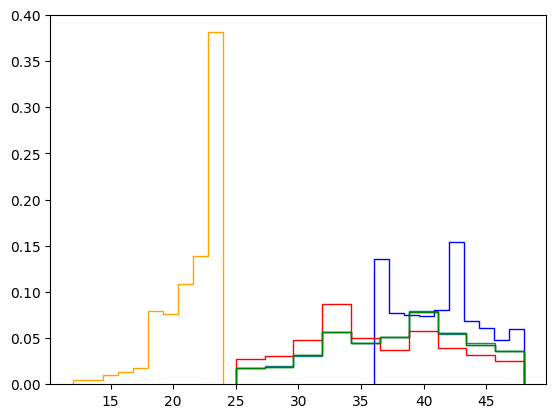

In [166]:
n_target = len(df_not_sampled) // 2
x_target_distribution = df_not_sampled["casp"].sample(n_target, replace=False)

plt.hist(df_not_sampled["casp"], histtype="step", density=True)
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

def sample_instance_with_x(x, eps=10):
    try:
        return df_not_sampled.loc[abs(df_not_sampled["casp"] - x) < eps].sample(1)
    except ValueError: # fallback if no instance possible
        return df_not_sampled.sample(1)

client2_ = [sample_instance_with_x(45) for x in tqdm(x_target_distribution)]
client2 = pd.concat(client2_)

client3 = df_not_sampled.drop(client2.index)

plt.hist(df_sampled["casp"], histtype="step", density=True, color='orange')
plt.hist(client2["casp"], histtype="step", density=True, color='blue')
plt.hist(client3["casp"], histtype="step", density=True, color='red')
plt.hist(x_target_distribution, histtype="step", density=True, color='green')

print(client2["casp"].mean())
print(client3["casp"].mean())

print(f'client2, N = {len(client2)}')
print(f'client3, N = {len(client3)}')

client2.to_csv(os.path.join(outdir_casp, f'3clients/client2.csv'), index=False, header=True)
client3.to_csv(os.path.join(outdir_casp, f'3clients/client3.csv'), index=False, header=True)

In [ ]:
split_and_save_datasets([df_sampled, client2, client3], outdir_casp + '3clients', num_folds=5, random_state=42)

5 clients

Dataset 1 Stats:
Mean casp: 25.850385038503852
Number of Samples: 909

Dataset 2 Stats:
Mean casp: 30.004437869822485
Number of Samples: 2704

Dataset 3 Stats:
Mean casp: 42.33560582584444
Number of Samples: 3227

Dataset 4 Stats:
Mean casp: 37.80706946616038
Number of Samples: 35816


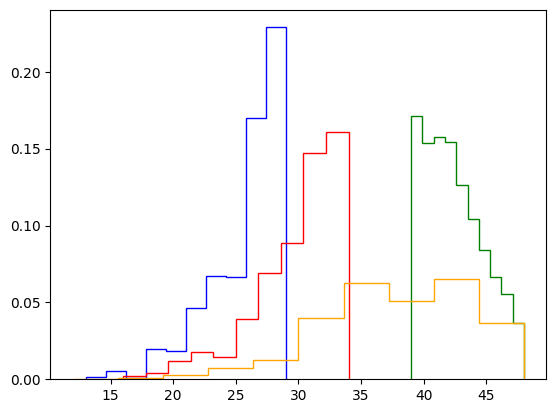

In [176]:
n_samples = len(df_sub)
n_forth = n_samples // 4

df_part1 = df_sub.iloc[:n_forth]
df_part2 = df_sub.iloc[n_forth:2 * n_forth]
df_part3 = df_sub.iloc[2 * n_forth:3 * n_forth]
df_part4 = df_sub.iloc[3 * n_forth:]


# Create masks to keep track of included instances for each part
included_mask1 = np.zeros(len(df_part1), dtype=bool)
included_mask2 = np.zeros(len(df_part2), dtype=bool)
included_mask3 = np.zeros(len(df_part3), dtype=bool)
included_mask4 = np.zeros(len(df_part4), dtype=bool)

# Create target casp distributions for each client
x_target_distribution1 = df_part1["casp"].sample(n_forth, replace=False)
x_target_distribution2 = df_part2["casp"].sample(n_forth, replace=False)
x_target_distribution3 = df_part3["casp"].sample(n_forth, replace=False)
x_target_distribution4 = df_part4["casp"].sample(n_forth, replace=False)

def sample_instance_with_x(df_part, included_mask, x, eps=10):
    try:
        available_indices = np.where(~included_mask)[0]  # Find available indices
        df_subset = df_part.iloc[available_indices]
        closest_indices = available_indices[np.abs(df_subset["casp"] - x) < eps]

        if len(closest_indices) > 0:
            selected_index = np.random.choice(closest_indices)
            included_mask[selected_index] = True  # Mark index as included
            return df_part.iloc[selected_index:selected_index + 1]
        else:
            return None
    except ValueError:  # fallback if no instance possible
        return None

# Sample instances for each target age distribution and create datasets
df_sampled1_ = [sample_instance_with_x(df_part1, included_mask1, 20) for x in x_target_distribution1]
df_sampled1 = pd.concat([x for x in df_sampled1_ if x is not None])

df_sampled2_ = [sample_instance_with_x(df_part2, included_mask2, 25) for x in x_target_distribution2]
df_sampled2 = pd.concat([x for x in df_sampled2_ if x is not None])

df_sampled3_ = [sample_instance_with_x(df_part3, included_mask3, 48) for x in x_target_distribution3]
df_sampled3 = pd.concat([x for x in df_sampled3_ if x is not None])

# All remaining data is included in df_sampled4
df_sampled4 = pd.concat([df_part1[~included_mask1], df_part2[~included_mask2],
                        df_part3[~included_mask3], df_part4[~included_mask4]])

print("Dataset 1 Stats:")
print(f"Mean casp: {df_sampled1['casp'].mean()}")
print(f"Number of Samples: {len(df_sampled1)}")

print("\nDataset 2 Stats:")
print(f"Mean casp: {df_sampled2['casp'].mean()}")
print(f"Number of Samples: {len(df_sampled2)}")

print("\nDataset 3 Stats:")
print(f"Mean casp: {df_sampled3['casp'].mean()}")
print(f"Number of Samples: {len(df_sampled3)}")

print("\nDataset 4 Stats:")
print(f"Mean casp: {df_sampled4['casp'].mean()}")
print(f"Number of Samples: {len(df_sampled4)}")

plt.hist(df_sampled1["casp"], histtype="step", density=True, color='blue')
plt.hist(df_sampled2["casp"], histtype="step", density=True, color='red')
plt.hist(df_sampled3["casp"], histtype="step", density=True, color='green')
plt.hist(df_sampled4["casp"], histtype="step", density=True, color='orange')

df_sampled1.to_csv(os.path.join(outdir_casp, '4clients/client1.csv'), index=False, header=True)
df_sampled2.to_csv(os.path.join(outdir_casp, '4clients/client2.csv'), index=False, header=True)
df_sampled3.to_csv(os.path.join(outdir_casp, '4clients/client3.csv'), index=False, header=True)
df_sampled4.to_csv(os.path.join(outdir_casp, '4clients/client4.csv'), index=False, header=True)

In [ ]:
split_and_save_datasets([df_sampled1, df_sampled2, df_sampled3, df_sampled4], outdir_casp + '4clients', num_folds=5, random_state=42)
